In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 81.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 35.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import TFBertModel, BertTokenizer, AutoTokenizer, TFAutoModel
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt

In [ ]:
code = pd.read_excel(r"/content/totalmerged.xlsx")
code

,input_text,target_text
0,#include <stdio.h>\n\nint main()\n{\n int n...,9
1,#include<stdio.h>\n#include<string.h>\nint mai...,9
2,#include<stdio.h>\n#include<string.h>\nmain()\...,9
3,#include<stdio.h>\n#include<string.h>\nint mai...,9
4,#include<stdio.h>\n#include<string.h>\nint mai...,9
...,...,...
759,#include<stdio.h>\n#include<stdlib.h>\n#includ...,8
760,#include<stdio.h>\n#include<stdlib.h>\n#includ...,9
761,#include <stdio.h> \n#include <stdlib.h>\nstru...,9
762,#include <stdio.h>\n#include <stdlib.h>\n\nstr...,10


In [ ]:
# Merge columns
code['merged'] = code['Question'] + ' ' + code['Code_with_Error']
code

In [ ]:
# Fill missing values with empty strings
code['merged'] = code['merged'].fillna('')

In [ ]:
# Load the codeBert tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
codeBERT_model  = TFAutoModel.from_pretrained("microsoft/codebert-base")


All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at microsoft/codebert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [ ]:
X_text = code["input_text"].values
y = code["target_text"].values

In [ ]:
# Tokenize and convert the textual data to vectors
X_vectors = []
for text in X_text:
    inputs = tokenizer.encode_plus(text, add_special_tokens=True, return_tensors='tf', max_length=512, truncation=True)
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']
    output = codeBERT_model(input_ids, attention_mask=attention_mask)[0][:, 0, :]
    X_vectors.append(output.numpy())

In [ ]:
X_vectors = np.array(X_vectors)
y = np.array(y)

In [ ]:
X_vectors

array([[[-0.1931388 , -0.1241635 , -0.11120333, ...,  0.02692465,
         -0.6377395 ,  0.5885658 ]],

       [[-0.09221207, -0.09902756, -0.08449391, ..., -0.00878088,
         -0.65689474,  0.55528694]],

       [[-0.16865984, -0.1489583 , -0.0962953 , ...,  0.0385789 ,
         -0.6582608 ,  0.56921524]],

       ...,

       [[-0.13114618, -0.14442287, -0.08315508, ..., -0.08174229,
         -0.62384754,  0.46277085]],

       [[-0.13488759, -0.15119776, -0.1321308 , ..., -0.08615353,
         -0.6107922 ,  0.5144401 ]],

       [[-0.18622437, -0.1219404 , -0.0988003 , ..., -0.10762602,
         -0.6130126 ,  0.53850937]]], dtype=float32)

In [ ]:

# Split the data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X_vectors, y, test_size=0.25, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)


In [ ]:

# # Define the LSTM model
# class LSTMModel(tf.keras.Model):
#     def __init__(self, input_shape, hidden_size, output_size):
#         super().__init__()
#         self.lstm = tf.keras.layers.LSTM(hidden_size, input_shape=input_shape)
#         self.fc = tf.keras.layers.Dense(output_size)

#     def call(self, inputs):
#         x = self.lstm(inputs)
#         x = self.fc(x)
#         return x


# # Define the model
# model = Sequential()
# model.add(LSTM(128, input_shape=(train_vectors.shape[1], train_vectors.shape[2])))
# model.add(Dropout(0.2))
# model.add(Dense(1, activation='sigmoid'))


# Build the LSTM model
input_layer = Input(shape=(X_vectors.shape[1], X_vectors.shape[2]))
lstm_layer1 = LSTM(units=128, dropout=0.2, recurrent_dropout=0.2)(input_layer)
output_layer = Dense(units=1, activation='relu')(lstm_layer1)
model = Model(inputs=input_layer, outputs=output_layer)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 768)]          0         
                                                                 
 lstm (LSTM)                 (None, 128)               459264    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 459,393
Trainable params: 459,393
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# # Create TensorFlow datasets
# train_dataset = tf.data.Dataset.from_tensor_slices((train_vectors, train_targets))
# train_dataset = train_dataset.batch(batch_size)


In [ ]:
# # Compile the model
# model = LSTMModel(input_shape, hidden_size, output_size)
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
#               loss='mean_squared_error',
#               metrics=['mae', 'mape', 'mse', 'r2'])

# # Compile the model with appropriate optimizer and regularization
# model.compile(optimizer='adam', loss='mse', metrics=['mse'])


# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae', 'mape', 'mse'])


In [ ]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, callbacks=[early_stopping])

Epoch 1/50
14/14 [==============================] - 4s 47ms/step - loss: 20.4741 - mae: 3.7519 - mape: 50.4505 - mse: 20.4741 - val_loss: 4.7657 - val_mae: 1.7108 - val_mape: 36.6276 - val_mse: 4.7657
Epoch 2/50
14/14 [==============================] - 0s 14ms/step - loss: 5.1495 - mae: 1.7943 - mape: 35.5019 - mse: 5.1495 - val_loss: 5.0650 - val_mae: 1.7324 - val_mape: 38.3554 - val_mse: 5.0650
Epoch 3/50
14/14 [==============================] - 0s 16ms/step - loss: 4.8017 - mae: 1.7876 - mape: 33.9246 - mse: 4.8017 - val_loss: 4.6728 - val_mae: 1.7680 - val_mape: 36.0332 - val_mse: 4.6728
Epoch 4/50
14/14 [==============================] - 0s 15ms/step - loss: 4.6558 - mae: 1.8387 - mape: 32.8733 - mse: 4.6558 - val_loss: 4.6777 - val_mae: 1.7928 - val_mape: 35.8520 - val_mse: 4.6777
Epoch 5/50
14/14 [==============================] - 0s 14ms/step - loss: 4.6567 - mae: 1.8466 - mape: 32.8845 - mse: 4.6567 - val_loss: 4.6659 - val_mae: 1.7741 - val_mape: 35.9530 - val_mse: 4.6659
Epo

In [ ]:
# Evaluate the model on train and test sets
feature_model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
X_train_features = feature_model.predict(X_train)
X_test_features = feature_model.predict(X_test)


6/6 [==============================] - 0s 4ms/step


In [ ]:
from sklearn.linear_model import LinearRegression
#from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from  .linear_model import RidgeCV

#regressor_model = #Regressor() 
regressor_model=RidgeCV()

In [ ]:
regressor_model.fit(X_train_features, y_train)

RidgeCV()

In [ ]:
y_train_pred = regressor_model.predict(X_train_features)
y_test_pred = regressor_model.predict(X_test_features)


In [ ]:

rmse_train = sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = sqrt(mean_squared_error(y_test, y_test_pred))
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
mape_train = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

In [ ]:
print("Train set results:")
print("RMSE: ", rmse_train)
print("MAE: ", mae_train)
print("MAPE: ", mape_train)
print("R2 score: ", r2_train)
      
print("Test set results:")
print("RMSE: ", rmse_test)
print("MAE: ", mae_test)
print("MAPE: ", mape_test)
print("R2 score: ", r2_test)

Train set results:
RMSE:  1.861969954894077
MAE:  1.5327899381308587
MAPE:  26.165631612684276
R2 score:  0.2606807460709216
Test set results:
RMSE:  2.105885824275061
MAE:  1.7416271628401574
MAPE:  29.967627073752446
R2 score:  0.09926675547995112


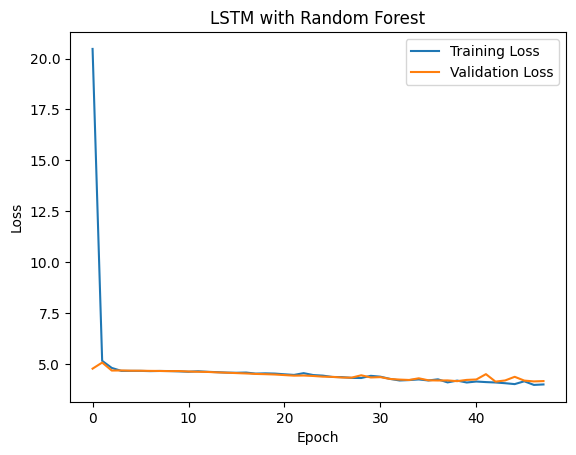

In [ ]:
# Plot the loss curves
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LSTM with Random Forest')
plt.legend()
plt.show()

In [ ]:
# Determine the optimal number of epochs
optimal_epochs = np.argmin(history.history['val_loss']) + 1
print("Optimal number of epochs: ", optimal_epochs)

Optimal number of epochs:  43


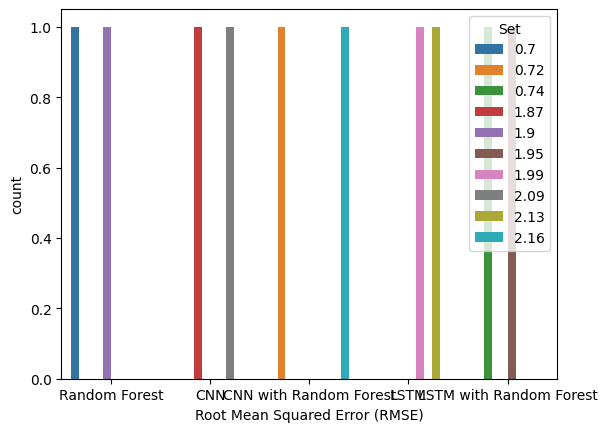

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
data = {'Random Forest': [0.70,1.90],
        'CNN': [1.87,2.09],
        'CNN with Random Forest': [0.72,2.16],
        'LSTM': [1.99,2.13],
        'LSTM with Random Forest': [0.74,1.95]}
df = pd.DataFrame(data)
df1 = df.melt(var_name='Root Mean Squared Error (RMSE)', value_name='Set')
sns.countplot(x='Root Mean Squared Error (RMSE)', hue='Set', data=df1)
plt.show()

Text(0, 0.5, 'R2 score')

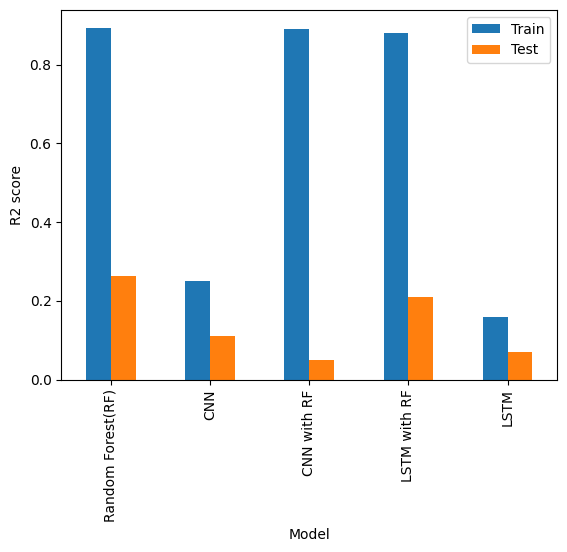

In [ ]:
df = pd.DataFrame({
    'Model vs RMSE value': ['Random Forest(RF)','CNN','CNN with RF','LSTM with RF','LSTM'],
        'Train': [0.8937,0.25,0.89,0.8808833929107769,0.15876747921481615],

    'Test': [0.2636,0.11,0.05,0.20899263342681007,0.07105510704396634]

})
  
# plotting graph
df.plot(x="Model vs RMSE value", y=["Train", "Test"], kind="bar")
plt.xlabel('Model')
plt.ylabel('R2 score')

<Axes: xlabel='Model vs R2 value'>

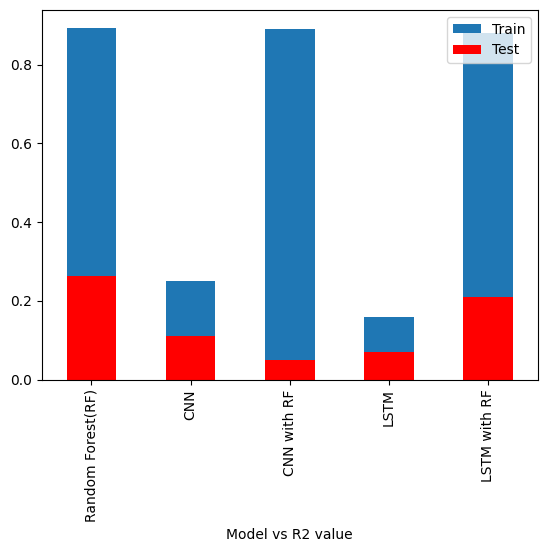

In [ ]:
df = pd.DataFrame({
    'Model vs R2 value': ['Random Forest(RF)','CNN','CNN with RF','LSTM','LSTM with RF'],
        'Test': [0.2636,0.11,0.05,0.07105510704396634,0.20899263342681007],

    'Train': [0.8937,0.25,0.89,0.15876747921481615,0.8808833929107769]
})

ax = df.plot(x="Model vs R2 value", y="Train", kind="bar")
# plotting age on the same axis
df.plot(x="Model vs R2 value", y="Test", kind="bar", ax=ax, color="red",legend="Model vs RMSE value")

Text(0, 0.5, 'R2 score')

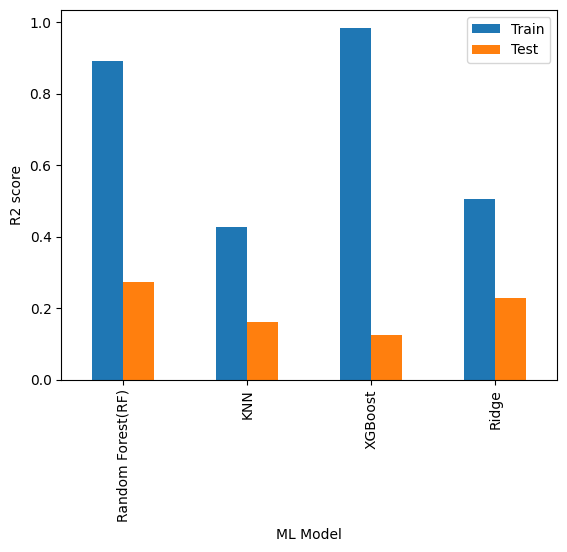

In [ ]:
df = pd.DataFrame({
    'Model vs R2 value': ['Random Forest(RF)','KNN','XGBoost','Ridge'],
        'Train': [0.891183,0.428,0.9855,0.506],

    'Test': [0.272935,0.161409,0.124931,0.229839]

})
  
# plotting graph
df.plot(x="Model vs R2 value", y=["Train", "Test"], kind="bar")
plt.xlabel('ML Model')
plt.ylabel('R2 score')